In [2]:
import numpy as np
import pandas as pd
import sys
import sys
sys.path.append('../libs')
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
import transform_lib
from icecream import ic

np.random.seed(200)

In [3]:
from matplotlib import pyplot as plt

import matplotlib

In [4]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData
wa-sa-D3, files: 14                     wa-sa-A3, files: 13                     wa-sa-C3, files: 13
wa-sa-A5, files: 13                     wa-sa-A2, files: 14                     wa-sa-A1, files: 13
wa-sa-A4, files: 13                     wa-sa-D2, files: 13                     wa-sa-B5, files: 13
wa-sa-B1, files: 13                     wa-sa-D4, files: 13                     wa-sa-C2, files: 13
wa-sa-C5, files: 13                     wa-sa-B2, files: 13                     wa-sa-D5, files: 14
wa-sa-B4, files: 13                     wa-sa-B3, files: 13                     wa-sa-C4, files: 13
wa-sa-D1, files: 13                     wa-sa-C1, files: 13   

### Get samples for negative control

In [5]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                     "wa-sa-A2", "wa-sa-B4",
                                     "wa-sa-C4",
                                     "wa-sa-B3",  "wa-sa-B2",
                                     "wa-sa-A5", "wa-sa-A3",
                                     "wa-sa-C2",
                                     "wa-sa-C3", # Pos
                                     "wa-sa-D3", # Zero
                                     "wa-sa-D4", 
                                     "wa-sa-B1", "wa-sa-A4",
                                     "wa-sa-A1", "wa-sa-D2",
                                     "wa-sa-C5", # Pos
                                     "wa-sa-D5", # Zero
                                     "wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [6]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
whitening_engine = transform_lib.WhitenTransformer()
num_cluster = int(2**len(prediction_axis) * 1.6)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
decision = decision_lib.ClusterHierarchyDensityClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     eps=0.2,
                                     contamination=0.004,
                                     density_quantile=0.03,
                                     prediction_axis=prediction_axis,
                                     )
df_decision = decision.predict(np_wa, verbose=1)

Time to remove Negatives: 0.004014015197753906 seconds.
Time for Clustering: 0.7835190296173096 seconds.
Time for Whitening: 0.028064727783203125 seconds.
Time for Cluster Features: 0.32032203674316406 seconds.
Time for Predictions: 0.10768699645996094 seconds.
Time for Cluster Features (2): 0.0 seconds.
Time to build Density estimation: 0.9986350536346436 seconds.
Time to compute point probabilies: 0.7834429740905762 seconds.


In [7]:
df = df_wa.iloc[:,:6]
pathogens = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
preds = df_decision.to_numpy()
n_cols = 2
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

In [8]:
num_pathogens = len(pathogens)
assert num_pathogens < 20 # cant deal with more labels
assert num_pathogens == preds.shape[1]

spacing = 20 // num_pathogens
colors = matplotlib.colormaps['tab20'].colors
colors = np.array([colors[spacing*i] for i in range(num_pathogens)])

In [9]:
colorsArray = np.zeros(shape = (len(df), 3))
for i in range(len(df)):
    color = np.zeros(3)
    row = preds[i]
    num_preds = np.sum(row)
    for j in range(num_pathogens):
        color += colors[j] * row[j]
    colorsArray[i] = color
    if num_preds:
        colorsArray[i] /= num_preds  

In [10]:
df.columns = pathogens

In [11]:
colorsArray.shape

(380426, 3)

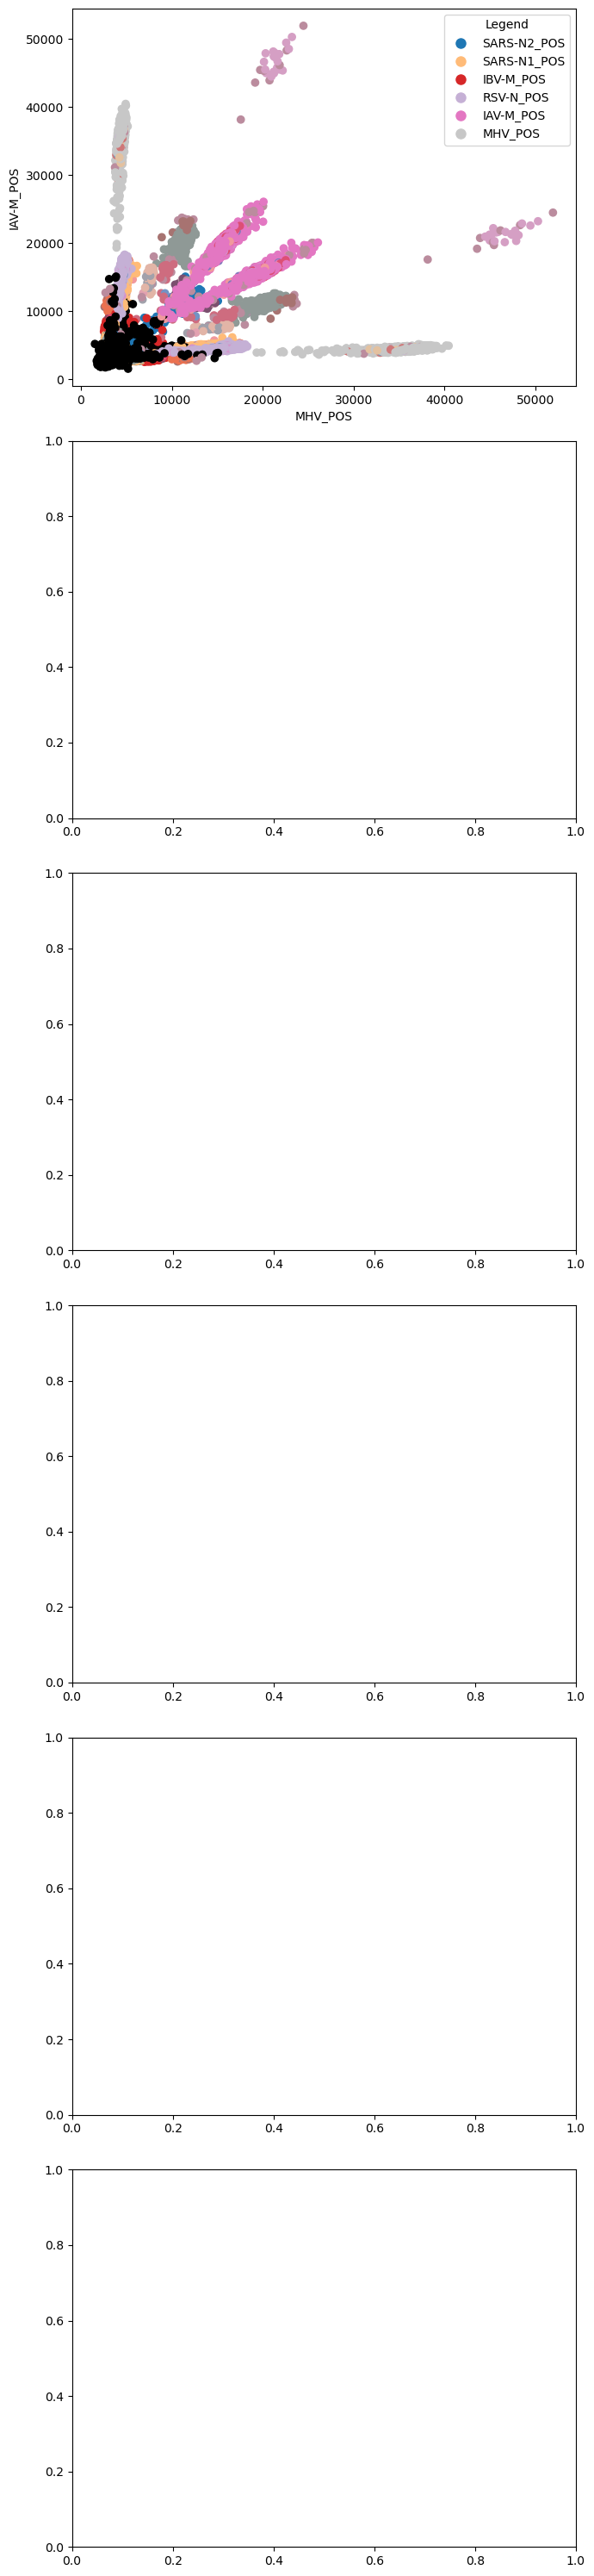

In [16]:
n = len(selected_pairs)
n_cols = 1
n_rows = n // n_cols + 0 if n % n_cols == 0 else 1

fig, ax = plt.subplots(n_rows, n_cols, sharex=False, sharey=False)
fig.set_figheight(5 * n_rows)
fig.set_figwidth(7 * n_cols)
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label='{}'.format(pathogens[idx])) for idx, c in enumerate(colors)]
# iterate over combinations for subplots
for i, (col_one, col_two) in enumerate(selected_pairs): 

    # false positives = 1, false negatives = -1
    x_features = df.loc[:, col_one].to_numpy()
    y_features = df.loc[:, col_two].to_numpy()

    ax[i].set_xlabel(col_one)
    ax[i].set_ylabel(col_two)
    ax[i].scatter(x_features, y_features, c = colorsArray)
    ax[i].legend(handles = legend_handles, loc='upper right', title='Legend')
fig.tight_layout()
plt.show()

In [10]:
df_decision

,SARS-N2_POS,SARS-N1_POS,IBV-M_POS,RSV-N_POS,IAV-M_POS,MHV_POS
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
380421,0,0,0,0,0,0
380422,0,0,0,0,0,0
380423,0,0,0,0,0,0
380424,0,0,0,0,0,0


## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.0002260623616682351, n_outlier: 86

Total error rate: 9.778557745440962e-05
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
     0.00002     0.000091    0.00019   0.000089   0.000187  0.00001

Precision (TP / (TP + FP)): 0.9942264556884766
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999693     0.995019    0.95928        1.0        1.0      1.0

Recall / TPR (TP / (TP + FN)): 0.9992445707321167
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
     0.99981     0.999029   0.998028   0.997832   0.999762 0.999751

Specificity / TNR (TN / (TN + FP)): 0.9999644160270691
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999997     0.999959    0.99983        1.0        1.0      1.0

Accuracy ((TP + TN) / (P + N)): 0.9999600052833557
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999996     0.999952   0.999823   0.999993   0.999998 0.999999

F1 (2 * (precision *

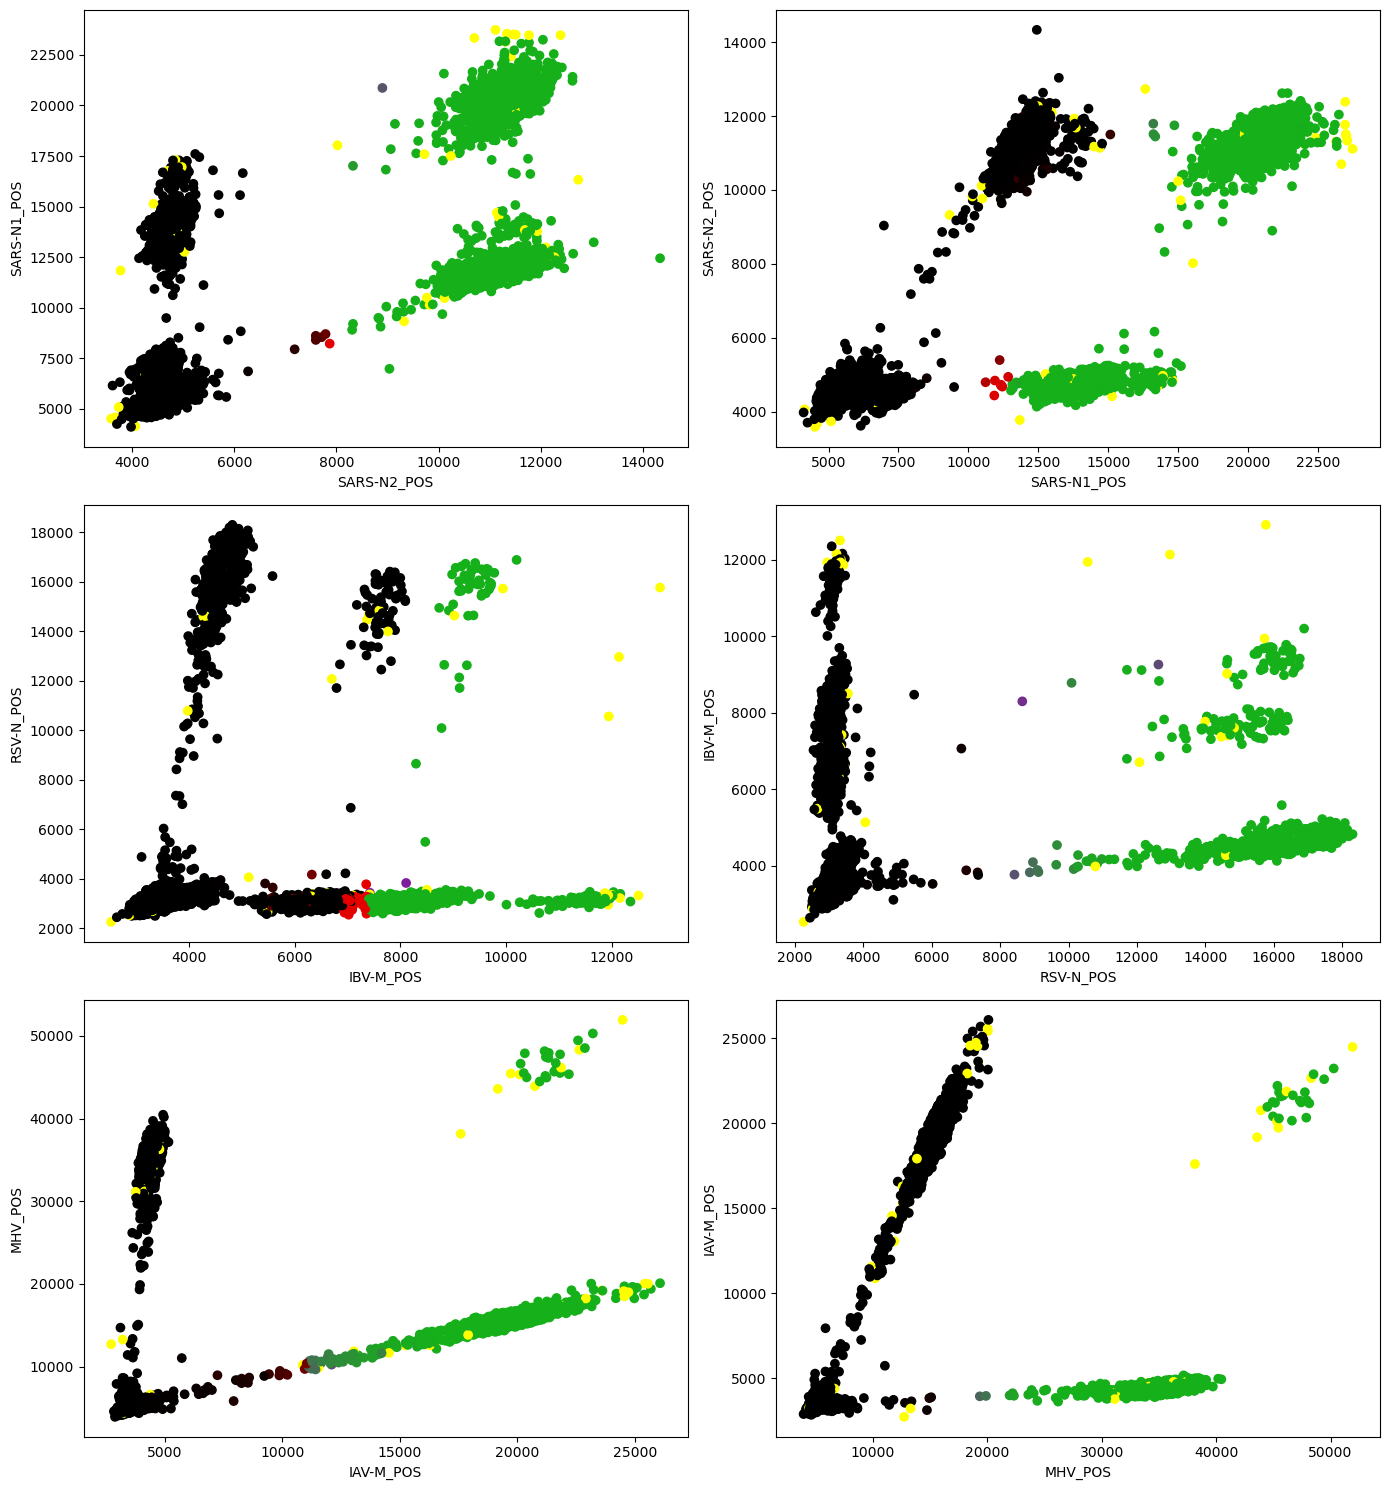

In [9]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = df_decision
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

validation_lib.validate_labels(df_ground_trouth, decision.probabilities_df, threshold=0.5)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        decision.probabilities_df,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=decision.No_neg_mask
        )